In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

# Data Cleaning & Exploration

In [2]:
data = pd.read_csv("Input/complaints.csv")

In [3]:
data.shape

(2326246, 18)

In [4]:
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2021-11-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,31707,NaN,NaN,Web,2021-11-01,In progress,Yes,NaN,4863965
4,2021-11-02,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,"Medical Data Systems, Inc.",VA,22033,NaN,NaN,Web,2021-11-02,In progress,Yes,NaN,4866449


In [5]:
data["Consumer complaint narrative"][13]

'Receiving daily telephone call ( s ) from XXXX XXXX XXXX identifying themselves as from an attorney \'s office and I am unable to decifer the name after asking 3 times. They ask me to confirm that my name is " prior married name ". I ask what they want and they repeat the question. I responded yes and they hang up. \n\nThe next call from that number was asking me if I was a different name - my maiden name which I recently change to. When I asked for clarification, they hung up. \n\nI have received a total of 6 calls in approx 2 days. They never divulge what they want after attempting to verify my name ( s )'

In [6]:
data["Product"][13]

'Credit reporting, credit repair services, or other personal consumer reports'

In [7]:
data["Consumer complaint narrative"][3401]

"I was looking through my report and noticed a vehicle that I returned to the dealership where it's reporting completely incorrect. I had the opportunity to talk to several lawmakers and friends, and learned some basic laws in regards to voluntary or repossession of a vehicle. Under the laws of MASS and UCC 9.506 as well as State RISA and MVISA statutes, a deficiency can not be claimed unless all of the required notices were properly and timely given, and all of the allowable redemption and cure time limits were adhered to. PLEASE HAVE THEM IMMEDIATELY REMOVE"

In [8]:
data["Product"][3401]

'Vehicle loan or lease'

### Select only 'product' and 'Consumer complaint narrative' columns

In [9]:
data = data[["Product", "Consumer complaint narrative"]]

In [10]:
data.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",NaN
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,Debt collection,NaN


In [11]:
data.isna().sum()

Product                               0
Consumer complaint narrative    1516903
dtype: int64

### Drop records with missing complaints

In [12]:
data.dropna(inplace=True)

In [13]:
data.shape

(809343, 2)

In [14]:
data.rename({"Consumer complaint narrative": "Complaint"}, 
            axis=1, inplace=True)

In [15]:
data.head()

,Product,Complaint
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
7,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...
8,"Credit reporting, credit repair services, or o...",I am a victim of Identity Theft & currently ha...
10,"Credit reporting, credit repair services, or o...",Two accounts are still on my credit history af...
13,"Credit reporting, credit repair services, or o...",Receiving daily telephone call ( s ) from XXXX...


In [16]:
data["Product"].unique()

array(['Vehicle loan or lease',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card or prepaid card',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Payday loan, title loan, or personal loan', 'Debt collection',
       'Checking or savings account', 'Student loan', 'Consumer Loan',
       'Money transfers', 'Credit card', 'Bank account or service',
       'Credit reporting', 'Prepaid card', 'Payday loan',
       'Other financial service', 'Virtual currency'], dtype=object)

### Create unique values for 'product'

In [17]:
product_map = {'Vehicle loan or lease': 'vehicle_loan',
              'Credit reporting, credit repair services, or other personal consumer reports':'credit_report',
              'Credit card or prepaid card': 'card',
              'Money transfer, virtual currency, or money service': 'money_transfer',
              'virtual currency': 'money_transfer',
              'Mortgage': 'mortgage',
               'Payday loan, title loan, or personal loan': 'loan',
               'Debt collection': 'debt_collection',
               'Checking or savings account': 'savings_account',
               'Credit card': 'card',
               'Bank account or service': 'savings_account',
               'Credit reporting': 'credit_report',
               'Prepaid card': 'card',
               'Payday loan': 'loan',
               'Other financial service': 'others',
               'Virtual currency': 'money_transfer',
               'Student loan': 'loan',
               'Consumer Loan': 'loan',
               'Money transfers': 'money_transfer'
              }

In [18]:
data.replace({"Product": product_map}, inplace=True)

In [19]:
data.head()

,Product,Complaint
1,vehicle_loan,I contacted Ally on Friday XX/XX/XXXX after fa...
7,credit_report,Hello This complaint is against the three cred...
8,credit_report,I am a victim of Identity Theft & currently ha...
10,credit_report,Two accounts are still on my credit history af...
13,credit_report,Receiving daily telephone call ( s ) from XXXX...


### Plot distribution of 'product' column

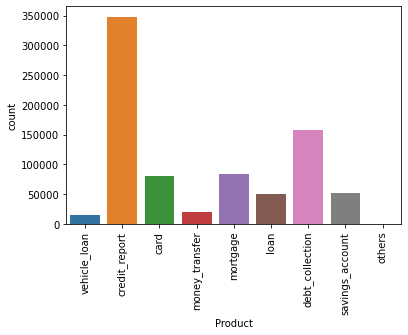

In [20]:
sns.countplot(x="Product", data=data)
plt.xticks(rotation=90)
plt.show()

In [21]:
data["Product"].value_counts()

credit_report      348053
debt_collection    157381
mortgage            84461
card                81042
savings_account     52274
loan                50710
money_transfer      20096
vehicle_loan        15034
others                292
Name: Product, dtype: int64

In [22]:
complaints = list(data["Complaint"])

In [23]:
len(complaints)

809343

### Convert data to lower case

In [24]:
complaints = [c.lower() for c in tqdm(complaints) ]

100%|██████████████████████████████████████████████████████████████████████| 809343/809343 [00:01<00:00, 556638.62it/s]


In [25]:
complaints[13]

'my credit reports list monies owed to xxxx. i have written to the collection agency, xxxx xxxx xxxx requesting proof that i owe monies on this account, but none was ever sent. i notified the credit agencies that this creditor never sent me the required proof, yet they continue to list this account on my credit report. \n\nmy credit reports list xxxx xxxx xxxx and xxxx for monies owed to xxxx. i submitted documentation that showed that the original creditor was paid however, the credit reporting agencies continue to list xxxx xxxx on my credit report. furthermore, two separate collection agencies can not be listed on my creditreport over the same account. \n\nmy credit reports list a bankruptcy that should have been deleted since the 7 years of reporting it has expired.'

In [26]:
complaints[3401]

'xxxx xxxx  sent me a email that it looked like my personal data may had been compromised. i opened it up and reviewed everything and there was several unknown inquiries and accounts that certainly did not belong to me. i pulled my credit to make sure, and these accounts i am reporting are definitely not mine. please remove these items from my report. \n\nbankruptcy chapter xxxx-dismissed xxxx {$0.00}'

### Tokenize the text

In [27]:
tokens = [word_tokenize(c) for c in tqdm(complaints)]

100%|█████████████████████████████████████████████████████████████████████████| 809343/809343 [19:02<00:00, 708.24it/s]


In [28]:
tokens[13]

['my',
 'credit',
 'reports',
 'list',
 'monies',
 'owed',
 'to',
 'xxxx',
 '.',
 'i',
 'have',
 'written',
 'to',
 'the',
 'collection',
 'agency',
 ',',
 'xxxx',
 'xxxx',
 'xxxx',
 'requesting',
 'proof',
 'that',
 'i',
 'owe',
 'monies',
 'on',
 'this',
 'account',
 ',',
 'but',
 'none',
 'was',
 'ever',
 'sent',
 '.',
 'i',
 'notified',
 'the',
 'credit',
 'agencies',
 'that',
 'this',
 'creditor',
 'never',
 'sent',
 'me',
 'the',
 'required',
 'proof',
 ',',
 'yet',
 'they',
 'continue',
 'to',
 'list',
 'this',
 'account',
 'on',
 'my',
 'credit',
 'report',
 '.',
 'my',
 'credit',
 'reports',
 'list',
 'xxxx',
 'xxxx',
 'xxxx',
 'and',
 'xxxx',
 'for',
 'monies',
 'owed',
 'to',
 'xxxx',
 '.',
 'i',
 'submitted',
 'documentation',
 'that',
 'showed',
 'that',
 'the',
 'original',
 'creditor',
 'was',
 'paid',
 'however',
 ',',
 'the',
 'credit',
 'reporting',
 'agencies',
 'continue',
 'to',
 'list',
 'xxxx',
 'xxxx',
 'on',
 'my',
 'credit',
 'report',
 '.',
 'furthermore',
 '

In [29]:
tokens[3401]

['xxxx',
 'xxxx',
 'sent',
 'me',
 'a',
 'email',
 'that',
 'it',
 'looked',
 'like',
 'my',
 'personal',
 'data',
 'may',
 'had',
 'been',
 'compromised',
 '.',
 'i',
 'opened',
 'it',
 'up',
 'and',
 'reviewed',
 'everything',
 'and',
 'there',
 'was',
 'several',
 'unknown',
 'inquiries',
 'and',
 'accounts',
 'that',
 'certainly',
 'did',
 'not',
 'belong',
 'to',
 'me',
 '.',
 'i',
 'pulled',
 'my',
 'credit',
 'to',
 'make',
 'sure',
 ',',
 'and',
 'these',
 'accounts',
 'i',
 'am',
 'reporting',
 'are',
 'definitely',
 'not',
 'mine',
 '.',
 'please',
 'remove',
 'these',
 'items',
 'from',
 'my',
 'report',
 '.',
 'bankruptcy',
 'chapter',
 'xxxx-dismissed',
 'xxxx',
 '{',
 '$',
 '0.00',
 '}']

### Remove stopwords

In [31]:
sw = stopwords.words('english')

In [32]:
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
tokens = [[word for word in t if word not in sw] for t in tqdm(tokens)]


  2%|█▎                                                                       | 14633/809343 [00:06<05:21, 2471.79it/s]


  4%|██▊                                                                      | 30905/809343 [00:13<05:26, 2386.15it/s]


  6%|████▎                                                                    | 47308/809343 [00:20<05:19, 2384.70it/s]


  8%|█████▊                                                                   | 64240/809343 [00:27<05:04, 2450.63it/s]


 10%|███████▏                                                                 | 80168/809343 [00:35<05:42, 2131.42it/s]


 12%|████████▋                                                                | 95798/809343 [00:42<05:13, 2277.47it/s]


 14%|██████████▏                                                             | 114082/809343 [00:49<04:32, 2555.21it/s]


 16%|███████████▋                                                            | 131198/809343 [00:57<05:00, 2254.83it/s]


 18%|█████████████                                                           | 147403/809343 [01:04<04:26, 2484.41it/s]


 20%|██████████████▌                                                         | 164234/809343 [01:11<04:57, 2166.01it/s]


 22%|████████████████                                                        | 181044/809343 [01:18<04:37, 2267.49it/s]


 24%|█████████████████▌                                                      | 197602/809343 [01:25<04:40, 2184.13it/s]


 26%|███████████████████                                                     | 213792/809343 [01:32<03:50, 2579.00it/s]


 27%|███████████████████▍                                                    | 218379/809343 [01:34<04:22, 2255.12it/s]

### Remove puctuation marks

In [ ]:
tokenizer =  RegexpTokenizer(r'\w+')

In [ ]:
tokens = [["".join(tokenizer.tokenize(word)) for word in t  
          if len(tokenizer.tokenize(word))> 0 ] for t in tqdm(tokens)]

In [ ]:
tokens[13]

In [ ]:
tokens[3401]

### Remove 'XXXX' and '000'

In [ ]:
tokens =  [[t for t in token if t not in ['xxxx','000']]for token in tqdm(tokens) ]

In [ ]:
tokens[13]

In [ ]:
tokens[3401]

### Check word count for couple of classes

In [ ]:
data["clean_complaints"] = tokens

In [ ]:
data.head()

In [ ]:
loan_complaints = list( data[data["Product"]=="loan"]["clean_complaints"] )

In [ ]:
loan_complaints = [token for complaint in tqdm(loan_complaints) for token in complaint]

In [ ]:
counter = Counter(loan_complaints)

In [ ]:
counter.most_common(10)

In [ ]:
card_complaints = list( data[data["Product"]=="card"]["clean_complaints"] )

In [ ]:
card_complaints = [token for complaint in tqdm(card_complaints) for token in complaint]

In [ ]:
counter = Counter(card_complaints)

In [ ]:
counter.most_common(10)

In [ ]:
counter = Counter([t for complaint in tqdm(tokens) for t in complaint])

In [ ]:
counter.most_common(10)

In [ ]:
# Unique tokens in dataset
len(counter.keys())

In [ ]:
clean_complaints =[" ".join(complaint) for complaint in tqdm(tokens)]

In [ ]:
clean_complaints[13]

In [ ]:
clean_complaints[3401]

# Data Preparation

### vectorize the data

In [ ]:
# min_df : it signifies that the token should present in at least min_df number of documents to be considered 
vect = CountVectorizer(min_df=200)

In [ ]:
X = vect.fit_transform(clean_complaints)

In [ ]:
X.shape

In [ ]:
y = data["Product"]

### Split data into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Model Training

### Create a multi-nomial Naive Bayes's Model

In [ ]:
model = MultinomialNB()

In [ ]:
model.fit(X_train, y_train)

### Predict on the test set

In [ ]:
test_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, test_pred)

In [ ]:
conf_mat = confusion_matrix(y_test, test_pred)

In [ ]:
conf_mat

In [ ]:
conf_mat = pd.DataFrame(conf_mat, columns=model.classes_, index=model.classes_)

In [ ]:
conf_mat

In [ ]:
sns.heatmap(conf_mat)
plt.show()

### Save vectorizer and model

In [ ]:
with open("Output/count_vect.pkl","wb") as f:
    pickle.dump(vect, f)
    
with open("Open/nb.pickle","wb") as f:
    pickle.dump(model,f)

# Prediction

In [ ]:
data["Complaint"][1545]

In [ ]:
data["Product"][1545]

In [ ]:
data["Complaint"][5001]

In [ ]:
data["Product"][5001]

In [ ]:
test_complaint_1 = data["Complaint"][1545]
test_complaint_2 = data["Complaint"][5001]
test_complaint = [test_complaint_1,test_complaint_2]

### Load the vectorizer and model objects

In [ ]:
vect = pickle.load(open("Output/count_vect.pkl","rb"))
model = pickle.load(open("Output/rb.pkl", "rb"))

### Process the data

In [ ]:
test_complaint = [r.lower() for r in test_complaint]

In [ ]:
test_complaint

In [ ]:
test_tokens = [word_tokenize(r) for r in test_complaint]

In [ ]:
test_tokens = [[word for word in t if word not in sw] for t in test_tokens]

In [ ]:
test_tokens = [["".join(tokenizer.tokenize(word)) for word in t
              if len(tokenizer.tokenize(word))>0 ] for t in test_tokens]

In [ ]:
test_tokens = [[t for t in token if t not in ["xxxx", "000"]]
              for token in test_tokens]

In [ ]:
clean_test_complaints = [" ".join(complaint) for complaint in test_tokens]

### Vectorize test data

In [ ]:
X_test = vect.transform(clean_test_complaints)

### Make predictions

In [ ]:
model.predict(X_test)